Dataset loaded successfully!
Targeting new column: 'Prove'

Training the XGBoost model on the new target...


/home/hi-born/miniconda3/envs/juror/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [00:47:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete!
Finding the best prediction threshold...

Found Best Threshold: 0.33
Achieved Accuracy: 0.7846

Final Classification Report (with Optimal Threshold):
              precision    recall  f1-score   support

         0.0       0.89      0.59      0.71        29
         1.0       0.74      0.94      0.83        36

    accuracy                           0.78        65
   macro avg       0.82      0.77      0.77        65
weighted avg       0.81      0.78      0.78        65


Confusion Matrix:
[[17 12]
 [ 2 34]]


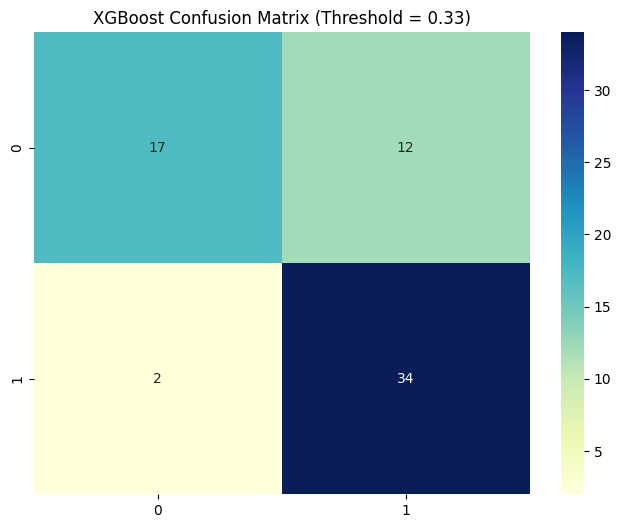

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# --- 1. Load Data and Define Target ---
try:
    df = pd.read_csv('dataset/final_dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'final_dataset.csv' not found. Please check the file path.")
    exit()

# Set the NEW target variable, as discovered in your script
target_col = 'Prove'
print(f"Targeting new column: '{target_col}'")

# --- 2. Prepare Data and Split ---
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# # Convert boolean columns to integers for XGBoost
# for col in X.columns:
#     if X[col].dtype == 'bool':
#         X[col] = X[col].astype(int)

# # The specific 1-based indices from your manager
# manager_indices_1_based = [14, 16, 18, 20, 25, 36, 37, 46, 58, 71, 75, 76, 79, 85, 88, 90, 94, 95, 96,
#                            107, 111, 112, 122, 124, 131, 132, 138, 144, 147, 148, 150, 156, 158, 160,
#                            169, 170, 173, 174, 175, 177, 179, 181, 187, 192, 206, 207, 210, 211, 212, 215]
# test_indices_0_based = [i - 2 for i in manager_indices_1_based]

# X_test = X.iloc[test_indices_0_based]
# y_test = y.iloc[test_indices_0_based]
# train_indices = np.delete(np.arange(len(df)), test_indices_0_based)
# X_train = X.iloc[train_indices]
# y_train = y.iloc[train_indices]

# --- 3. Train the XGBoost Model ---
# Using a configuration known to be robust
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=4, # Using a slightly shallower depth to reduce overfitting
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


print("\nTraining the XGBoost model on the new target...")
xgb_model.fit(X_train, y_train)
print("Training complete!")

# --- 4. Find the Optimal Threshold ---
print("Finding the best prediction threshold...")
y_probs_test = xgb_model.predict_proba(X_test)[:, 1]

best_accuracy = 0
best_threshold = 0
# Test a range of potential thresholds
for threshold in np.arange(0.1, 0.9, 0.01):
    preds = (y_probs_test >= threshold).astype(int)
    acc = accuracy_score(y_test, preds)
    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = threshold

print(f"\nFound Best Threshold: {best_threshold:.2f}")
print(f"Achieved Accuracy: {best_accuracy:.4f}")

# --- 5. Evaluate with the Best Threshold ---
y_pred_final = (y_probs_test >= best_threshold).astype(int)

print("\nFinal Classification Report (with Optimal Threshold):")
print(classification_report(y_test, y_pred_final))

# Display a confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=xgb_model.classes_,
            yticklabels=xgb_model.classes_)
plt.title(f'XGBoost Confusion Matrix (Threshold = {best_threshold:.2f})')
plt.show()